# Acceleration prediction error
Running an entire simulation with the mathematical predictor model (system based model) to reproduce a real time series trajectory of the ship is perhaps the most straight forward way to assess the accuracy of this predictor model.

![](figures/deviating_simulations.PNG)
<p align=centered>Fig.1 - The simulation and real data from the experiment is in complete different states in the later part of the simulations.</p>

However, after a while when the simulation and real data begins to deviate (see Fig.1) this comparison is not so meaningfull anymore, as the simulation and real data are now in complete different states. If the simulation model is instead allowed to catch up with the real data, by updating with the real state, the simulated state and real state can be kept closer to each other, to allow for a more realistic comparison, also during the later stages of the simulation. This is instead the error of an online predictor that can make predictions into the nearby future, a number of steps ahead in a discrete time series. If the online predictor should only predict one step ahead, the predictor error is reduced to an acceleration prediction error, where the mathematical models ability to predict acceleration is assessed. When the inertia of ship and water is known, or assumed to be known, this is very closely related to assess the models ability to predict the forces correctly.

The acceleration predictor error \epsilon_a is defined as the difference between real acceleration $a$ and the predicted acceleration $\hat{a}$,
$$\epsilon_a = a - \hat{a}$$

## Calculating the acceleration prediction error

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[07/03/23 10:51:29] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=520345;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=101792;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/03/23 10:51:35] INFO     Kedro project phd                                                      ]8;id=836374;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=175053;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=431019;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=780445;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=533787;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=35947;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=502297;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=138552;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=909801;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=463958;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=794809;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=506373;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=55905;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=643422;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=269114;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=177157;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=415481;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=999765;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model_no_wind = model_loaders['vmm_abkowitz_diminished']()
model_wind = model_loaders["MDL_modular_propeller_rudder_wind"]()

In [6]:
model_wind.ship_parameters

{'T': 0.284,
 'L': 7.0,
 'CB': 0.41152752056103203,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'scale_factor': 30,
 'x_r': -3.3168459992407717,
 'TWIN': 1,
 'x_p': -3.326486749598252,
 'D': 0.17,
 'w_p0': 0.151,
 'n_prop': 2,
 'x_R': -3.326486749598252,
 'y_R': 0,
 'z_R': 0,
 'A_R': 0.07777777777777778,
 'b_R': 0.23933333333333334,
 'w_f': 0.151,
 'r_0': 0.085,
 'x': 0.13733333333333336,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225}

In [7]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [8]:
np.rad2deg(0.038)

2.177239621497128

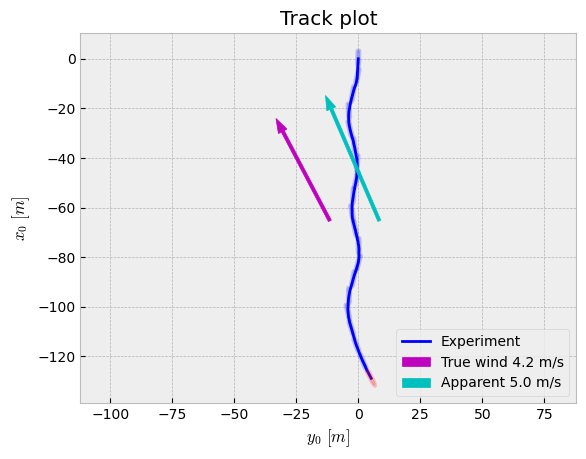

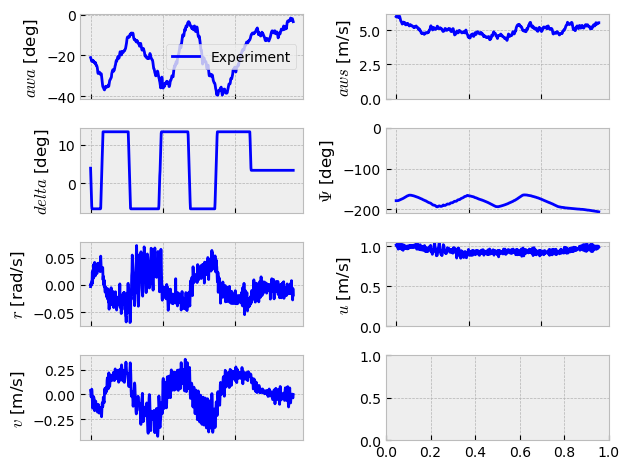

In [503]:
id = '8'
loader = time_series[id]
data_raw = loader()
data = load(raw_data=data_raw)

delta0 = np.deg2rad(-1.5)
data['delta']-=delta0  # Neutral rudder angle added


data.drop(columns=['mission','date'], inplace=True)

dataframes = {
    'Experiment':data,
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
plot(dataframes, keys=['u','v','r','delta','psi','aws','awa'], time_window=time_window, units=units, symbols=symbols_dict);

## Acceleration

In [521]:
#rev_guess = 14.5
#rev_guess = 7.2
rev_guess = 8.1
data['rev'] = rev_guess
states = data[['x0','y0','psi','u','v','r']]
control=data[model_wind.control_keys]

#model_wind.parameters['Yvdot'] = -0.006109387408263365*0.1
#model_wind.parameters['Xudot'] = 0.00017880704448812042*5


#Modifying the wind coefficients:
model_wind2 = model_wind.copy()
C_y_factor = 1.0
C_ys = {key:C_y_factor*value for key,value in model_wind.parameters.items() if 'C_y' in key}
model_wind2.parameters.update(C_ys)

C_n_factor = 1.0
C_ns = {key:C_n_factor*value for key,value in model_wind.parameters.items() if 'C_n' in key}
model_wind2.parameters.update(C_ns)


resistance_factor = 1.8
model_wind2.parameters['Xu']*=resistance_factor
model_wind2.parameters['Xuu']*=resistance_factor
model_wind2.parameters['Yv']*=5

acceleration = model_wind2.calculate_acceleration(states_dict=states, control=control)

In [522]:
df_acceleration = pd.DataFrame(acceleration[:,0,:].transpose(), columns=['u1d','v1d','r1d'], index=data.index)

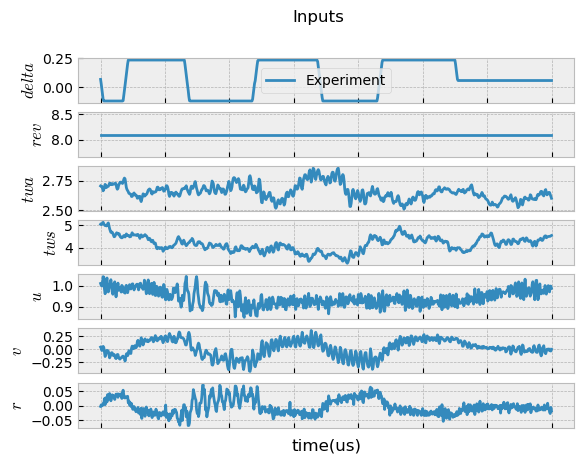

In [523]:
input_keys = model_wind.control_keys + ['u','v','r']
fig,axes=plt.subplots(nrows=len(input_keys))
fig.suptitle('Inputs')
data_plot = data.copy()
data_plot['twa'] = np.unwrap(data_plot['twa'])


for key,ax in zip(input_keys, axes):
    data_plot.plot(y=key, label='Experiment', ax=ax)
    ax.set_ylabel(fr"${symbols_dict[key]}$")
    ax.get_legend().set_visible(False)
    ax.set_xticklabels([])
    
axes[0].legend();

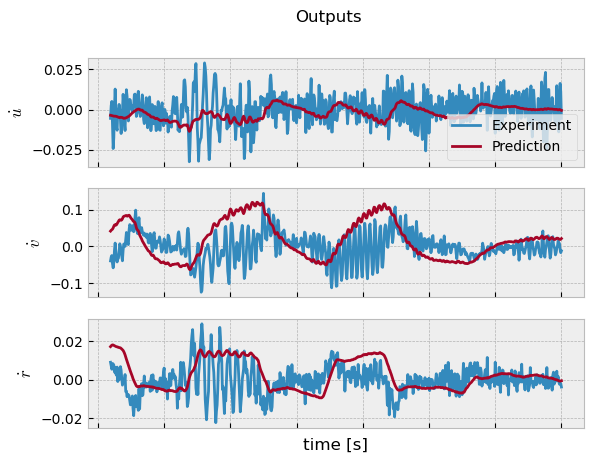

In [539]:
fig,axes=plt.subplots(nrows=3)
fig.suptitle('Outputs')

for key,ax in zip(['u1d','v1d','r1d'], axes):
    window=20
    data.rolling(window=window).mean().plot(y=key, label='Experiment', ax=ax)
    df_acceleration.rolling(window=window).mean().plot(y=key, label='Prediction', ax=ax)
    ax.set_ylabel(fr"${symbols_dict[key]}$")
    ax.get_legend().set_visible(False)
    ax.set_xticklabels([])
    ax.set_xlabel('') 

axes[-1].set_xlabel('time [s]') 
axes[0].legend();
fig.savefig("figures/acceleration_prediction_error.png")

<p align=center>Fig.2 - It seems the the transverse acceleration $\dot{v}$ is underpredicted by the model.</p>

## Force

If the interia is further assumed to be correct, a force prediction error $\epsilon_F$ can instead be considered,
$$\epsilon_F = F - \hat{F}$$
This gives a more direct assessment of the force prediction model. One must however bare in mind that the assumed intertia also has some uncertainty that has now been excluded from the assessment. 

In [525]:
df_force_predicted = pd.DataFrame(model_wind2.calculate_forces(states_dict=states, control=control))

In [526]:
df_force = model_wind2.forces_from_motions(data=data)

In [527]:
df_force.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,V,U,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,aws,awa,tws,twa,global time,rev,fx,fy,mz
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,3.1543,-3.089885,1.0117,-1.9057,-2.4102,59.301755,18.319519,0.0150,-0.3439,6.0640,-0.4138,5.1219,-0.3854,5.1998,-0.4779,4.2790,40.0,3.1416,0.0024,0.0091,0.0115,-0.0031,0.0636,-0.1742,-9.6200,-0.3518,6.1495,-0.4809,5.2121,-0.3840,5.7776,4.8558,0.068246,1.0117,1.0117,-0.0390,1.010931,0.039446,-3.128885,0.0150,-0.003001,-0.045351,-0.114609,0.027510,80.864612,2508.117843,0.000000,0.000000,5.96355,-0.36790,5.050350,2.707036,4594.341608,8.1,-19.437393,-93.392211,27.447193
0.199933,3.1537,-3.112985,1.0020,8.0943,-0.1835,59.301753,18.319519,0.0155,-0.3456,6.0606,-0.4200,5.1212,-0.3853,5.2505,-0.4809,4.3314,40.0,3.1416,0.0062,-0.0015,0.0223,-0.0016,0.0278,-0.3037,-9.8003,-0.3649,6.0336,-0.4927,5.1236,-0.3840,5.8549,4.9546,0.029383,1.0020,1.0020,-0.0165,1.001864,0.016532,-3.129485,0.0155,0.002499,-0.016974,-0.211422,-0.017490,80.851359,2507.902642,-0.214924,-0.011594,5.94425,-0.37445,5.032360,2.703302,4594.541541,8.1,-7.313045,-175.251229,-28.977919
0.399999,3.1542,-3.154785,0.9988,8.0943,2.4953,59.301751,18.319519,0.0155,-0.3472,6.0608,-0.4192,5.1222,-0.3863,5.3001,-0.4787,4.3814,40.0,3.1416,0.0105,0.0054,0.0175,0.0040,0.0506,-0.2061,-9.9880,-0.3665,6.0528,-0.4389,5.1290,-0.3954,5.8984,4.9874,-0.017371,0.9988,0.9988,0.0258,0.998468,-0.025766,-3.128985,0.0155,-0.001000,0.079622,0.231822,0.005001,80.845327,2507.694737,-0.423059,-0.019009,5.97560,-0.38095,5.051086,2.704435,4594.741607,8.1,34.206614,191.572425,15.234046
0.599985,3.1540,-3.108885,1.0146,8.0943,4.9060,59.301749,18.319519,0.0190,-0.3487,6.0616,-0.4207,5.1237,-0.3889,5.3533,-0.4805,4.4358,40.0,3.1416,0.0114,0.0328,-0.0099,0.0053,0.1197,-0.1378,-10.1026,-0.3665,6.0704,-0.4542,5.1414,-0.4156,5.9789,5.0728,-0.059446,1.0146,1.0146,-0.0203,1.014391,0.020595,-3.129185,0.0190,0.000000,0.146375,0.161316,0.032499,80.836479,2507.491286,-0.626418,-0.027304,6.02465,-0.39105,5.110813,2.683489,4594.941593,8.1,62.904962,136.395446,44.455774
0.799962,3.1540,-3.078585,1.0450,8.0943,7.4406,59.301747,18.319518,0.0259,-0.3497,6.0606,-0.4243,5.1234,-0.3925,5.4074,-0.4861,4.4918,40.0,3.1416,0.0069,0.0357,-0.0321,0.0048,0.0463,-0.2841,-9.8864,-0.3637,6.0541,-0.5376,5.1256,-0.4363,6.0623,5.1701,-0.103683,1.0450,1.0450,-0.0506,1.043662,0.052854,-3.129185,0.0259,0.006499,-0.012546,-0.111683,-0.002486,80.822954,2507.283458,-0.834246,-0.040828,6.05820,-0.40000,5.137702,2.665303,4595.141570,8.1,-5.543187,-89.520817,-7.429299


In [528]:
df_force_predicted.head()

,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_H,Y_H,N_H,cog,aws,awa,X_W,Y_W,N_W,X_D,Y_D,N_D
time(us),,,,,,,,,,,,,,,,,,,
0.000000,35.034061,30.935076,1.351467,0.093029,-0.270483,6.782018,-22.560294,-19.608268,-39.687773,-4.126028,-3.089885,5.96355,-0.36790,-13.807144,66.204647,69.712109,-2.750820,33.298892,43.025787
0.199933,35.320275,31.187803,1.351638,0.049584,-0.159649,3.611040,-12.012076,-19.131541,-16.845961,-4.375073,-3.112985,5.94425,-0.37445,-13.610330,66.763669,69.885458,-1.713718,53.528748,53.498310
0.399999,35.427880,31.282818,1.351717,-0.017133,-0.121786,-1.248175,4.152038,-19.056137,25.338842,3.880549,3.128400,5.97560,-0.38095,-13.645061,68.453103,71.231043,-1.540165,92.543770,79.263630
0.599985,34.923833,30.837744,1.351398,-0.125125,-0.393508,-9.110882,30.307227,-19.601335,-20.998206,-3.397523,-3.108885,6.02465,-0.39105,-13.695047,71.121977,73.324960,-2.852146,41.012890,100.234665
0.799962,33.996215,30.018658,1.351097,-0.212063,-0.924914,-15.439042,51.357768,-21.473132,-55.455832,-12.751308,-3.078585,6.05820,-0.40000,-13.688942,73.283612,74.929042,-6.068330,2.388738,113.535502


In [529]:
model_wind.X_D_eq

Eq(X_D, X_H(u, v, r, delta) + X_P(u, v, r, rev) + X_R(u, v, r, delta, thrust) + X_W(C_x2, C_x1, awa, C_x3, C_x4, aws, A_XV, C_x0, rho_A, C_x5))

In [530]:
df_force_predicted['fx'] = run(model_wind2.lambda_X_D, inputs=df_force_predicted)
df_force_predicted['fy'] = run(model_wind2.lambda_Y_D, inputs=df_force_predicted)
df_force_predicted['mz'] = run(model_wind2.lambda_N_D, inputs=df_force_predicted)

## Total force

<Axes: xlabel='time(us)'>

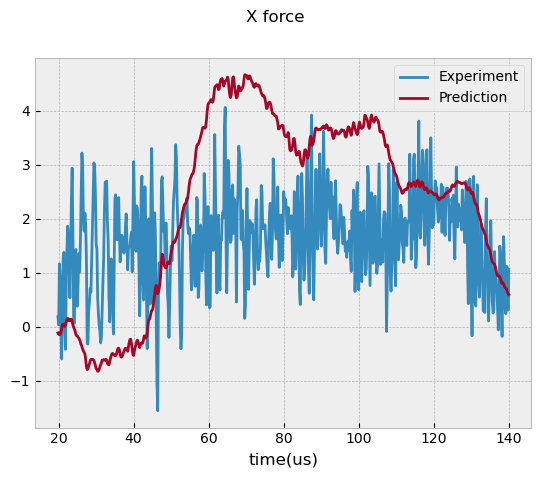

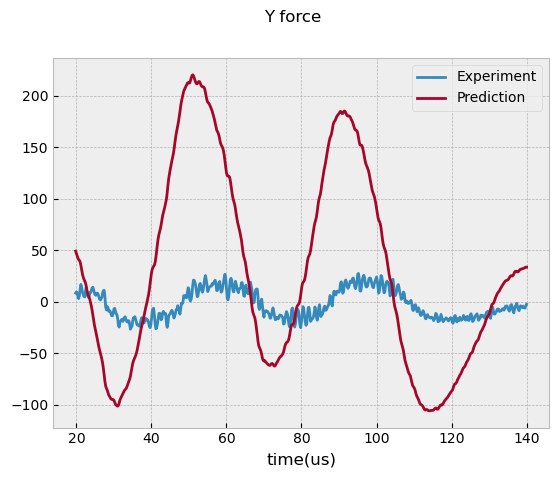

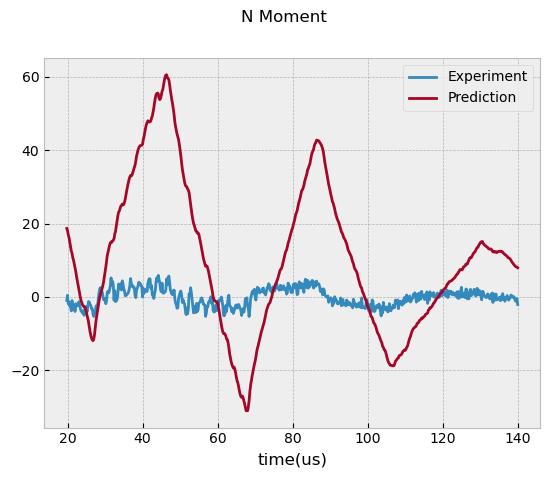

In [531]:
fig,ax=plt.subplots()
fig.suptitle('X force')
window=100
df_force.rolling(window=window).mean().plot(y='fx', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fx', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('Y force')

df_force.rolling(window=window).mean().plot(y='fy', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='fy', label='Prediction', ax=ax)

fig,ax=plt.subplots()
fig.suptitle('N Moment')

df_force.rolling(window=window).mean().plot(y='mz', label='Experiment', ax=ax)
df_force_predicted.rolling(window=window).mean().plot(y='mz', label='Prediction', ax=ax)

## Force components

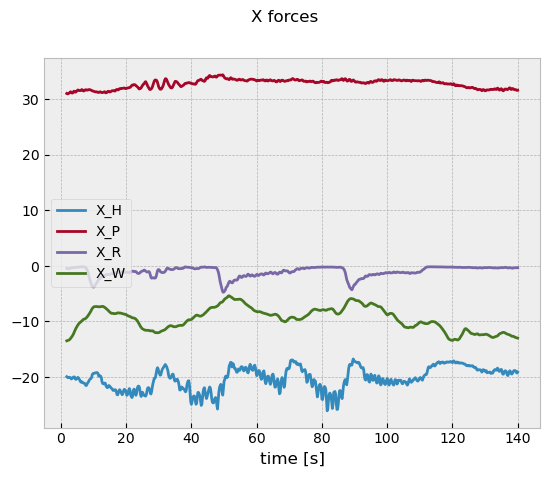

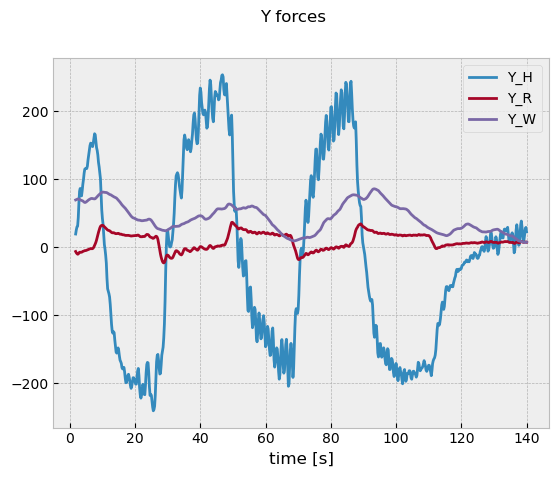

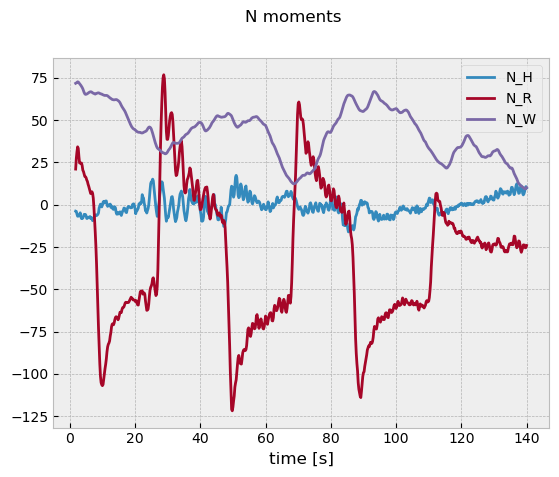

In [532]:
keys = list(get_function_subs(model_wind.X_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('X forces')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model_wind.Y_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('Y forces')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')
    
keys = list(get_function_subs(model_wind.N_D_eq).values())
fig,ax=plt.subplots()
fig.suptitle('N moments')

for key in keys:
    window=10
    df_force_predicted.rolling(window=window).mean().plot(y=key, ax=ax)
    ax.set_xlabel('time [s]')



In [533]:
model_wind.subsystems['hull'].equations['N_H']

Eq(N_H, N_{r}*r + N_{ur}*r*u + N_{u}*u + N_{v}*v)

In [534]:
model_wind.subsystems['hull'].equations['Y_H']

Eq(Y_H, Y_{r}*r + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

## Simulate

In [535]:
data_ = data.copy()
#data_['twa'] = smallest_signed_angle(mean_angle(data_['twa']))
#data_['tws'] = data_['tws'].mean()
result_wind = model_wind2.simulate(data_)

data['beta'] = smallest_signed_angle(data['beta'])
result_wind['beta'] = smallest_signed_angle(result_wind['beta'])


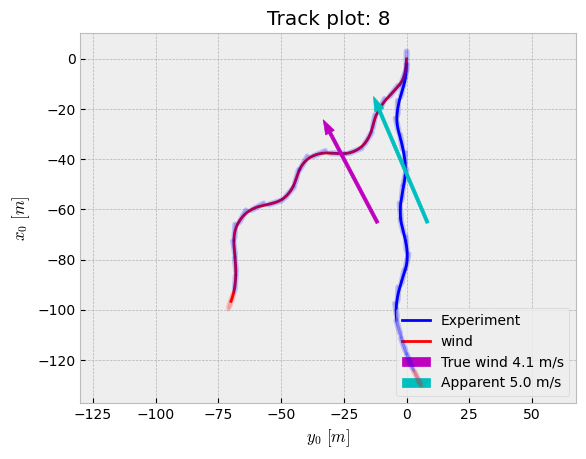

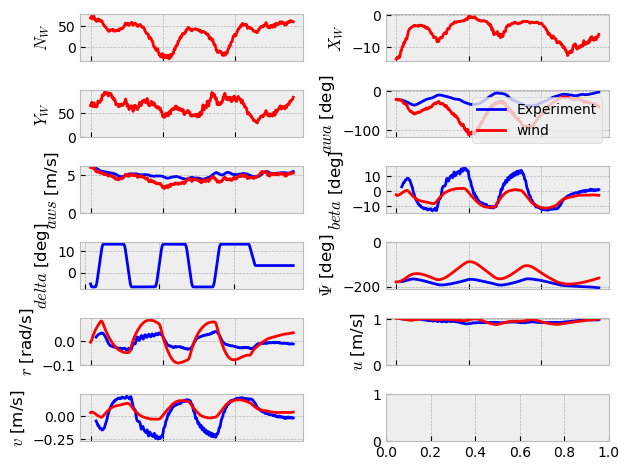

In [542]:
dataframes = {
    'Experiment':data.rolling(window=20).mean(),
    'wind':result_wind
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W','beta'], time_window=time_window, units=units, symbols=symbols_dict);

In [544]:
np.rad2deg(data['beta'].mean())

-1.028942163830826

## Model scale vs. full scale wind forces

![](https://media.happyyachting.com/product-images/XL/joysway-dragon-flite-95-rtr-2.jpg)

![](http://1.bp.blogspot.com/-aNdr4iRbrxA/UAJNjrLxeuI/AAAAAAAABNQ/wyIDdddOBaA/s640/Reliance+Sail+Plan.jpeg)

In [537]:
np.sqrt(ship_data['scale_factor'])*5

27.386127875258307

## Conclusions
* The present example corresponds to a full scale apparent wind speed of 27 m/s, which should be considered a sever condition.
* acceleration prediction error $\epsilon_a$ and force prediction error $\epsilon_F$ are usefull measures to assess the prediction model error, that can help to highlight the weak spots of a model.
* The wind forces seems to have a large influence on the total forces acting on the ship.
* The wind speed and wind force coefficients also have large uncertainties.
* The wind yaw moment in head winds has a destabilizing effect which can make the simulation diverge very rappidly from the real data if the apparent wind angle (awa) changes sign at the wrong place, which seems to be the case in the example above. 

### Present uncertainties in the prediction model:
* The hydrodynamic model has <u>low uncertainty</u> since it has been proven to work in a laboratory environment without wind.
* The aerodynamic model has <u>high uncertainty</u> since it is based on coefficients from wind tunnel tests with a similar ship.
* The wind speed has <u> medium uncertainty</u> since it was measured on the model, but is probably disturbed. A more robust wind speed prediction, for instance by assuming that the wind is constant during the test can perhaps reduce the uncertainty?
* The wave force influence is neglected in this model, which also adds some uncertainty. Assumtion: the wave forces are expected to have a large impact on the first order motions which can be neglected when long term motions during a whole zigzag manoeuvre should be predicted.
* Some initial neutral rudder angle is needed for the ship to go straight, even for cases when no wind is present. There seems to be some unsymmetry in how the ship was build, the rudders where mounted etc. This calls for a small (~2 deg) initial rudder angle. This initial neutral rudder angle is <u>uncertain</u> and needs further investigations. 
* The propeller speed is unknown. The propeller is run at fixed power (at some setting 70%,80%...). The propeller speed can however be estimated with <u>low/medium uncertainty</u> under these conditions.

## Action plan
- [ ] Estimate the neutral rudder angle (or other means to make the ship go straight)
- [x] Double check wind force coefficients
- [ ] System identification of wind forces